# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [0]:
import pandas as pd
import re
from google.colab import drive
drive.mount('/content/drive')

In [0]:

root_dir = '/content/drive/My Drive/Colab Notebooks/MLinMB/Group_Project_MLMB2020/'
# !ls '/content/drive/My Drive/Colab Notebooks/MLinMB/Group_Project_MLMB2020'

## Mutational catalogs and activities - WGS data

In [0]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv (root_dir + "project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,Biliary-AdenoCA::SP117759,Biliary-AdenoCA::SP117621,Biliary-AdenoCA::SP117425,Biliary-AdenoCA::SP117930,Biliary-AdenoCA::SP99287,Biliary-AdenoCA::SP99293,Biliary-AdenoCA::SP99289,Biliary-AdenoCA::SP99297,Biliary-AdenoCA::SP99301,Biliary-AdenoCA::SP99305,Biliary-AdenoCA::SP99309,Biliary-AdenoCA::SP99313,Biliary-AdenoCA::SP99317,Biliary-AdenoCA::SP99321,Biliary-AdenoCA::SP99325,Biliary-AdenoCA::SP99329,Biliary-AdenoCA::SP99333,Biliary-AdenoCA::SP99337,Biliary-AdenoCA::SP99341,Biliary-AdenoCA::SP99345,Biliary-AdenoCA::SP99113,Biliary-AdenoCA::SP99185,Biliary-AdenoCA::SP99209,Biliary-AdenoCA::SP99213,Biliary-AdenoCA::SP99221,Biliary-AdenoCA::SP99225,Biliary-AdenoCA::SP99241,Bladder-TCC::SP1086,Bladder-TCC::SP1003,Bladder-TCC::SP1677,...,Uterus-AdenoCA::SP92195,Uterus-AdenoCA::SP89957,Uterus-AdenoCA::SP92268,Uterus-AdenoCA::SP92707,Uterus-AdenoCA::SP89687,Uterus-AdenoCA::SP90269,Uterus-AdenoCA::SP94933,Uterus-AdenoCA::SP95126,Uterus-AdenoCA::SP95646,Uterus-AdenoCA::SP89443,Uterus-AdenoCA::SP89651,Uterus-AdenoCA::SP94060,Uterus-AdenoCA::SP92787,Uterus-AdenoCA::SP92723,Uterus-AdenoCA::SP92364,Uterus-AdenoCA::SP95406,Uterus-AdenoCA::SP91746,Uterus-AdenoCA::SP92332,Uterus-AdenoCA::SP91730,Uterus-AdenoCA::SP92947,Uterus-AdenoCA::SP91666,Uterus-AdenoCA::SP90245,Uterus-AdenoCA::SP90893,Uterus-AdenoCA::SP89519,Uterus-AdenoCA::SP94917,Uterus-AdenoCA::SP92659,Uterus-AdenoCA::SP94332,Uterus-AdenoCA::SP94661,Uterus-AdenoCA::SP93652,Uterus-AdenoCA::SP90125,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,242,171,144,292,72,190,291,24,23,122,114,98,49,54,542,191,68,91,73,62,58,264,198,74,21,62,289,197,202,157,...,144,65,80,109,184,110,528,278,137,83,72,93,91,76,457,57,99,281,284,82,118,194,161,50,205,692,222,91,97,146,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,187,130,112,155,43,117,178,14,26,61,98,69,17,43,595,119,43,53,55,25,22,120,114,65,17,40,192,113,108,98,...,126,48,50,41,160,66,326,202,97,58,46,61,82,49,358,63,57,220,247,52,90,146,106,19,185,1040,166,42,46,123,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [0]:
## Activities:
PCAWG_wgs_act = pd.read_csv (root_dir + "project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,SBS8,SBS9,SBS10a,SBS10b,SBS11,SBS12,SBS13,SBS14,SBS15,SBS16,SBS17a,SBS17b,SBS18,SBS19,SBS20,SBS21,SBS22,SBS23,SBS24,SBS25,SBS26,SBS27,SBS28,SBS29,SBS30,SBS31,SBS32,SBS33,SBS34,SBS35,SBS36,SBS37,SBS38,SBS39,SBS40,SBS41,SBS42,SBS43,SBS44,SBS45,SBS46,SBS47,SBS48,SBS49,SBS50,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,0,0,0,0,0,0,0,0,0,806,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9477,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
nonPCAWG_wgs_mut = pd.read_csv (root_dir + "project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,ALL::SJBALL020704_D1,ALL::SJBALL020877_D1,ALL::SJBALL020984_D1,ALL::SJBALL021058_D1,ALL::SJBALL021083_D1,ALL::SJBALL021305_D1,ALL::SJBALL021373_D1,ALL::SJBALL063_D,ALL::SJBALL153_D,ALL::SJBALL231_D,ALL::SJBALL239_D,ALL::SJBALL247_D,ALL::SJBALL255_D,ALL::SJBALL263_D,ALL::SJBALL264_D,ALL::SJBALL267_D,ALL::SJERG021891_D1,ALL::SJHYPER150_D,ALL::SJHYPER206_D,ALL::SJHYPER227_D,ALL::SJHYPO020_D,ALL::SJHYPO109_D,ALL::SJHYPO110_D,ALL::SJHYPO146_D,ALL::SJHYPO147_D,ALL::SJBALL020649_D1,AML::SNU_WGS_04_S1,AML::SNU_WGS_05_S1,AML::758168,AML::400220,...,Stomach-AdenoCa::pfg136T,Stomach-AdenoCa::pfg138T,Stomach-AdenoCa::pfg142T,Stomach-AdenoCa::pfg143T,Stomach-AdenoCa::pfg144T,Stomach-AdenoCa::pfg145T,Stomach-AdenoCa::pfg146T,Stomach-AdenoCa::pfg151T,Stomach-AdenoCa::pfg156T,Stomach-AdenoCa::pfg157T,Stomach-AdenoCa::pfg160T,Stomach-AdenoCa::pfg164T,Stomach-AdenoCa::pfg166T,Stomach-AdenoCa::pfg167T,Stomach-AdenoCa::pfg173T,Stomach-AdenoCa::pfg180T,Stomach-AdenoCa::pfg181T,Stomach-AdenoCa::pfg182T,Stomach-AdenoCa::pfg205T,Stomach-AdenoCa::pfg212T,Stomach-AdenoCa::pfg213T,Stomach-AdenoCa::pfg217T,Stomach-AdenoCa::pfg220T,Stomach-AdenoCa::pfg222T,Stomach-AdenoCa::pfg228T,Stomach-AdenoCa::pfg258T,Stomach-AdenoCa::pfg272T,Stomach-AdenoCa::pfg277T,Stomach-AdenoCa::pfg282T,Stomach-AdenoCa::pfg311T,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,7,4,9,19,6,13,7,11,9,7,7,7,1,19,18,10,11,8,7,4,3,8,12,5,13,3,11,8,11,8,...,125,14,42,241,254,461,653,70,64,81,224,84,118,162,305,298,791,256,253,187,106,248,175,318,104,124,178,244,64,175,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,4,4,4,14,6,12,10,6,3,4,5,2,3,7,12,7,4,6,6,4,1,5,4,1,12,0,3,3,3,3,...,57,12,20,176,181,195,293,36,21,68,175,49,66,89,206,169,391,108,134,114,65,140,80,172,55,86,58,188,63,136,48,70,126,88,35,54,16,112,31,91


In [0]:
nonPCAWG_wgs_act = pd.read_csv (root_dir + "project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,SBS8,SBS9,SBS10a,SBS10b,SBS11,SBS12,SBS13,SBS14,SBS15,SBS16,SBS17a,SBS17b,SBS18,SBS19,SBS20,SBS21,SBS22,SBS23,SBS24,SBS25,SBS26,SBS27,SBS28,SBS29,SBS30,SBS31,SBS32,SBS33,SBS34,SBS35,SBS36,SBS37,SBS38,SBS39,SBS40,SBS41,SBS42,SBS43,SBS44,SBS45,SBS46,SBS47,SBS48,SBS49,SBS50,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,0,0,0,0,0,0,0,0,0,4284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [0]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv (root_dir + "project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,AML::TCGA-AB-2810-03B-01W-0728-08,AML::TCGA-AB-2811-03B-01W-0728-08,AML::TCGA-AB-2812-03B-01W-0728-08,AML::TCGA-AB-2813-03B-01W-0728-08,AML::TCGA-AB-2814-03D-01W-0755-09,AML::TCGA-AB-2815-03B-01W-0728-08,AML::TCGA-AB-2816-03B-01W-0728-08,AML::TCGA-AB-2817-03B-01W-0728-08,AML::TCGA-AB-2818-03B-01W-0728-08,AML::TCGA-AB-2819-03B-01W-0728-08,AML::TCGA-AB-2820-03B-01W-0728-08,AML::TCGA-AB-2821-03B-01W-0728-08,AML::TCGA-AB-2822-03D-01W-0755-09,AML::TCGA-AB-2824-03B-01W-0728-08,AML::TCGA-AB-2825-03D-01W-0755-09,AML::TCGA-AB-2826-03B-01W-0728-08,AML::TCGA-AB-2827-03B-01W-0728-08,AML::TCGA-AB-2828-03B-01W-0728-08,AML::TCGA-AB-2829-03B-01W-0728-08,AML::TCGA-AB-2830-03B-01W-0728-08,AML::TCGA-AB-2831-03A-01W-0726-08,AML::TCGA-AB-2833-03B-01W-0728-08,AML::TCGA-AB-2834-03B-01W-0728-08,AML::TCGA-AB-2835-03B-01W-0728-08,AML::TCGA-AB-2836-03B-01W-0728-08,AML::TCGA-AB-2838-03A-01W-0726-08,AML::TCGA-AB-2839-03B-01W-0728-08,AML::TCGA-AB-2841-03B-01W-0728-08,AML::TCGA-AB-2842-03A-01W-0726-08,AML::TCGA-AB-2843-03B-01W-0728-08,...,Eye-Melanoma::TCGA-VD-A8KB-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KD-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KE-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KF-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KG-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KH-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KI-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KJ-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KK-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KL-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KM-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KN-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-A8KO-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8M-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8N-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8O-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8P-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8Q-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8R-01A-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8S-01B-11D-A39W-08,Eye-Melanoma::TCGA-VD-AA8T-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A87T-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A87U-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A87W-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A87Y-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A880-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A881-01A-12D-A39W-08,Eye-Melanoma::TCGA-WC-A882-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A883-01A-12D-A39W-08,Eye-Melanoma::TCGA-WC-A884-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,...,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,0,4,1,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
##Activities
TCGA_wes_act = pd.read_csv(root_dir + "project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,SBS8,SBS9,SBS10a,SBS10b,SBS11,SBS12,SBS13,SBS14,SBS15,SBS16,SBS17a,SBS17b,SBS18,SBS19,SBS20,SBS21,SBS22,SBS23,SBS24,SBS25,SBS26,SBS27,SBS28,SBS29,SBS30,SBS31,SBS32,SBS33,SBS34,SBS35,SBS36,SBS37,SBS38,SBS39,SBS40,SBS41,SBS42,SBS43,SBS44,SBS45,SBS46,SBS47,SBS48,SBS49,SBS50,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
other_wes_mut = pd.read_csv(root_dir + "project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,ALL::TARGET-10-PAPLDL-03A-01D,ALL::TARGET-10-PAPSPG-04A-01D,ALL::TARGET-10-PAPZNK-03A-01D,ALL::TARGET-10-PAPZNK-04A-01D,ALL::TARGET-10-PARAKF-04A-01D,ALL::TARGET-10-PARBRK-04A-01D,ALL::TARGET-10-PARFTR-04A-01D,ALL::TARGET-10-PARIAD-03A-01D,ALL::TARGET-10-PARIAD-04A-01D,ALL::TARGET-10-PARJZZ-04A-01D,ALL::TARGET-10-PARPNM-04A-01D,ALL::TARGET-10-PARPRW-04A-01D,ALL::TARGET-10-PASFXA-03A-01D,ALL::TARGET-10-PASLZM-03A-01D,AML::TARGET-20-PABLDZ-04A-01D,AML::TARGET-20-PABLDZ-09A-02D,AML::TARGET-20-PADZCG-04A-01D,AML::TARGET-20-PADZCG-09A-01D,AML::TARGET-20-PAEAKL-09A-01D,AML::TARGET-20-PAECCE-04A-01D,AML::TARGET-20-PAEERJ-04A-01D,AML::TARGET-20-PAEERJ-09A-01D,AML::TARGET-20-PAEFGR-04A-01D,AML::TARGET-20-PAEFGT-04A-01D,AML::TARGET-20-PAEFGT-09A-01D,AML::TARGET-20-PAEIKD-04A-01D,AML::TARGET-20-PAKERZ-04A-01D,AML::TARGET-20-PAKERZ-09A-01D,AML::TARGET-20-PAKIWK-04A-01D,AML::TARGET-20-PAKIWK-09A-01D,...,Skin-BCC::5-VS039-T1,Skin-BCC::5-VS040-T1,Skin-BCC::5-VS041-T1,Skin-BCC::5-VS042-T1,Skin-BCC::5-VS043-T1,Skin-BCC::5-VS045-T1,Skin-BCC::5-VS046-T1,Skin-BCC::5-VS047-T1,Skin-BCC::5-VS048-T1,Skin-BCC::5-VS050-T1,Skin-BCC::5-VS052-T1,Skin-BCC::5-VS054-T1,Skin-BCC::5-VS055-T1,Skin-BCC::5-VS056-T1,Skin-BCC::5-VS058-T1,Skin-BCC::5-VS097-T1,Skin-BCC::5-VS097-T2,Thy-AdenoCa::PTC-10C,Thy-AdenoCa::PTC-1C,Thy-AdenoCa::PTC-28C,Thy-AdenoCa::PTC-46C,Thy-AdenoCa::PTC-50C,Thy-AdenoCa::PTC-515C,Thy-AdenoCa::PTC-53C,Thy-AdenoCa::PTC-54C,Thy-AdenoCa::PTC-70C,Thy-AdenoCa::PTC-7C,Thy-AdenoCa::PTC-88C,Head-SCC::V-04,Head-SCC::V-108,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,2,2,7,1,5,0,1,4,3,2,8,2,9,2,13,13,27,11,20,21,16,33,24,47,10,0,0,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,2,1,2,2,1,1,0,1,1,3,1,2,0,11,5,18,5,5,6,3,5,2,47,4,0,0,1,0,0,0,0,0,0,1,0,0


In [0]:
other_wes_act = pd.read_csv(root_dir + "project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,SBS8,SBS9,SBS10a,SBS10b,SBS11,SBS12,SBS13,SBS14,SBS15,SBS16,SBS17a,SBS17b,SBS18,SBS19,SBS20,SBS21,SBS22,SBS23,SBS24,SBS25,SBS26,SBS27,SBS28,SBS29,SBS30,SBS31,SBS32,SBS33,SBS34,SBS35,SBS36,SBS37,SBS38,SBS39,SBS40,SBS41,SBS42,SBS43,SBS44,SBS45,SBS46,SBS47,SBS48,SBS49,SBS50,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# My Load Data


In [0]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import sklearn
import sklearn.manifold

In [0]:
class Dataset:
    def __init__(self, mut_dir, act_dir):
        self.mut = pd.read_csv (mut_dir)
        self.act = pd.read_csv (act_dir)
        self.extract()
    def extract(self):
        self.X_96 = self.mut.T[2:].to_numpy(dtype=float)
        self.n = self.X_96.shape[0]
        self.X_1 = self.X_96.sum(axis = 1)
        # self.X_6 = 
        # self.X_L24 = 
        # self.X_R24 = 
        self.Y_c = PCAWG_wgs_mut.columns[2:].str.split('::').str[0].to_numpy()
        self.Y_t = PCAWG_wgs_mut.columns[2:].str.split('::').str[0].str.split('-').str[1].to_numpy()
        self.Y_r = PCAWG_wgs_mut.columns[2:].str.split('-').str[0].to_numpy()

def LoadDataset(name, root_dir = ""):
    mut_dir = root_dir + "project_data/catalogs/%s/%s.96.csv" % (name[:3], name)
    act_dir = root_dir + "project_data/activities/%s/%s.activities.csv" % (name[:3], name)
    return Dataset(mut_dir, act_dir)

names = ['WGS_PCAWG', 'WGS_Other', 'WES_TCGA', 'WES_Other']
Datasets = [LoadDataset(name, root_dir=root_dir) for name in names]
PCAWG_wgs, nonPCAWG_wgs, TCGA_wes, other_wes = Datasets

In [0]:
channel_names = PCAWG_wgs.mut.T[0:1].values + PCAWG_wgs.mut.T[1:2].values
channel_names = channel_names.flatten()
channel_names = np.array(list(s[3:] + s[1:3] for s in channel_names))
# channel_names

In [0]:
Counter(PCAWG_wgs.Y_c).most_common()

[('Liver-HCC', 326),
 ('Prost-AdenoCA', 286),
 ('Panc-AdenoCA', 241),
 ('Breast-AdenoCA', 198),
 ('CNS-Medullo', 146),
 ('Kidney-RCC', 144),
 ('Ovary-AdenoCA', 113),
 ('Lymph-BNHL', 107),
 ('Skin-Melanoma', 107),
 ('Eso-AdenoCA', 98),
 ('Lymph-CLL', 95),
 ('CNS-PiloAstro', 89),
 ('Panc-Endocrine', 85),
 ('Stomach-AdenoCA', 75),
 ('ColoRect-AdenoCA', 60),
 ('Head-SCC', 57),
 ('Myeloid-MPN', 56),
 ('Uterus-AdenoCA', 51),
 ('Lung-SCC', 48),
 ('Thy-AdenoCA', 48),
 ('Kidney-ChRCC', 45),
 ('CNS-GBM', 41),
 ('Bone-Osteosarc', 38),
 ('Lung-AdenoCA', 38),
 ('Biliary-AdenoCA', 35),
 ('Bladder-TCC', 23),
 ('SoftTissue-Liposarc', 19),
 ('CNS-Oligo', 18),
 ('Cervix-SCC', 18),
 ('Bone-Benign', 16),
 ('SoftTissue-Leiomyo', 15),
 ('Breast-LobularCA', 13),
 ('Bone-Epith', 11),
 ('Myeloid-AML', 11),
 ('Myeloid-MDS', 4),
 ('Breast-DCIS', 3),
 ('Cervix-AdenoCA', 2)]

In [0]:
def EvenShuffle(labels):
    # evenly shuffle ids so that for all k, distribution within each of k-fold is roughly the same
    ls = defaultdict(list)
    for i in range(len(labels)):
        ls[labels[i]].append(i)
    def merge(left, right):
        ret, l, r = [], 0, 0
        n, m = len(left), len(right)
        for i in range(n + m):
            if i + 1 == (n + m) * (r + 1) // m:
                ret.append(right[r])
                r += 1
            else:
                ret.append(left[l])
                l += 1
        return ret
    ids = []
    for label in npr.permutation(list(ls.keys())):
        now = npr.permutation(ls[label])
        ids = now if len(ids) == 0 else merge(ids, now)
    return ids

class Task:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n = self.X.shape[0]
        self.ids = EvenShuffle(self.Y)
    def subset(self, ids):
        return Task(self.X[ids], self.Y[ids])
    def predict_all(self, predictor):
        predictor.fit(self.X, self.Y)
        predicts = predictor.predict(self.X)
        return predicts
    def evaluate(self, y_pred):
        accs = np.sum(y_pred == self.Y) / self.n
        return accs
    def split(self, train_size = 0.8):
        if type(train_size) == float:
            train_size = int(self.n * train_size)
        else:
            train_size = int(train_size)
        left_ids = self.ids[:train_size]
        right_ids = self.ids[train_size:]
        return self.subset(left_ids), self.subset(right_ids)
    def kfold(self, k):
        for i in range(k):
            l, r = i * self.n // k, (i + 1) * self.n // k
            tids = self.ids[:l] + self.ids[r:]
            kids = self.ids[l : r]
            yield self.subset(tids), self.subset(kids)
    def cutoff_rare(self, limit = 50):
        count = dict(Counter(self.Y).most_common())
        ids = [i for i, y in enumerate(self.Y) if count[y] >= limit]
        return self.subset(ids)

In [0]:
def PlotLabelSplit(train, test, name = ''):
    plt.figure(figsize = [15, 15])
    labels, train_count, test_count, train_perc, test_perc  = [], [], [], [], []
    for label, count in Counter(train.Y).most_common():
        labels.append(label)
        train_count.append(np.sum(train.Y == label))
        test_count.append(np.sum(test.Y == label))
        train_perc.append(train_count[-1] / train.n * 100)
        test_perc.append(test_count[-1] / test.n * 100)
    x = np.arange(len(labels))  # the label locations
    width = 0.46  # the width of the bars
    def add_count_text(rects, counts):
        for i, rect in enumerate(rects):
            plt.annotate('{}'.format(counts[i]), xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', rotation=(45 if counts[i]>=100 else 0))
    rects1 = plt.bar(x - width/2, train_perc, width, label='Train')
    rects2 = plt.bar(x + width/2, test_perc, width, label='Test')
    add_count_text(rects1, train_count)
    add_count_text(rects2, test_count)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Percentage')
    plt.title('Percentage by label group')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

In [0]:
class Normalizer:
    def __init__(self, X):
        self.fit(X)
    def fit(self, X):
        self.X = X
        self.X_mean = np.mean(self.X, axis = 0)
        self.X_std = np.std(self.X, axis = 0)
    def normalize(self, X):
        return (X - self.X_mean) / self.X_std
    def revert(self, X):
        return X * self.X_std + self.X_mean
    @staticmethod
    def normalize_all(X, *Xs):
        # to avoid using validation set
        n = Normalizer(X)
        return n, tuple([n.normalize(X)] + [n.normalize(x) for x in Xs])
    @staticmethod
    def normalize_all_task(T, *Ts):
        # to avoid using validation set
        n = Normalizer(T.X)
        return n, tuple([Task(n.normalize(T.X), T.Y)] + [Task(n.normalize(t.X), t.Y) for t in Ts])

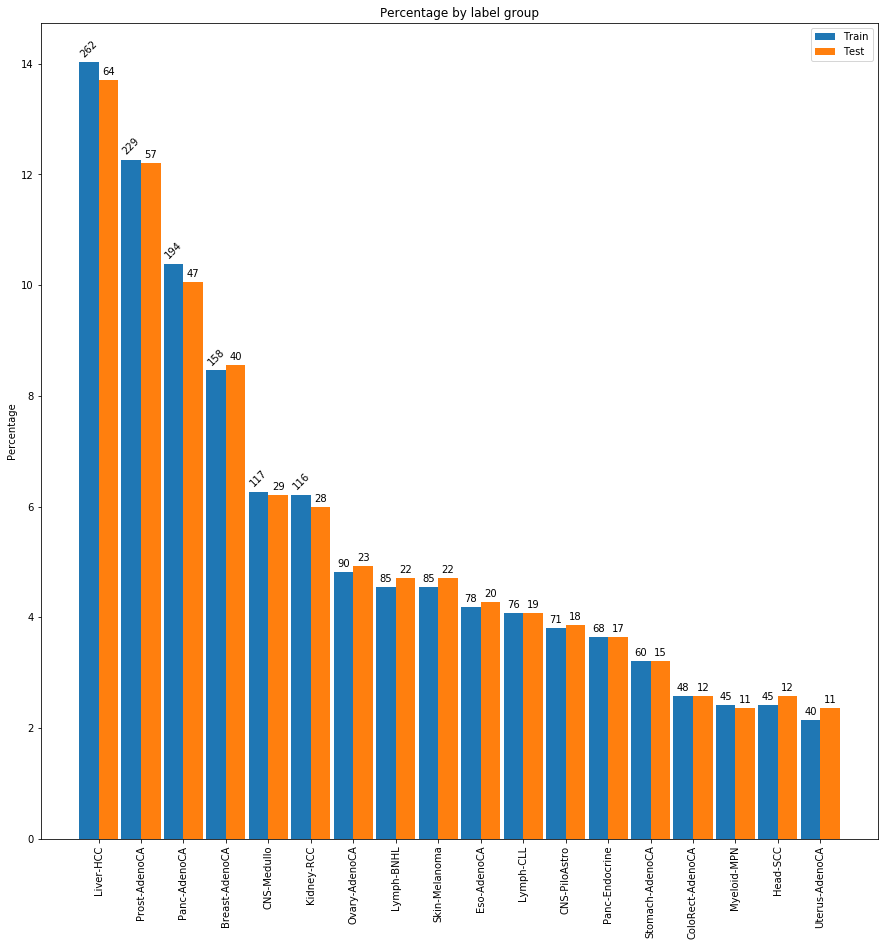

In [0]:
npr.seed(0)
raw_tasks = sum([[Task(dataset.X_96, dataset.Y_t), Task(dataset.X_96, dataset.Y_r), Task(dataset.X_96, dataset.Y_c)] for dataset in Datasets], [])
# t1 = raw_tasks[2]
t1 = raw_tasks[2].cutoff_rare(50)
t1.X = np.log(t1.X + 1)
t1t, t1v = t1.split()
PlotLabelSplit(t1t, t1v)
t1n, (t1tn, t1vn) = Normalizer.normalize_all_task(t1t, t1v)

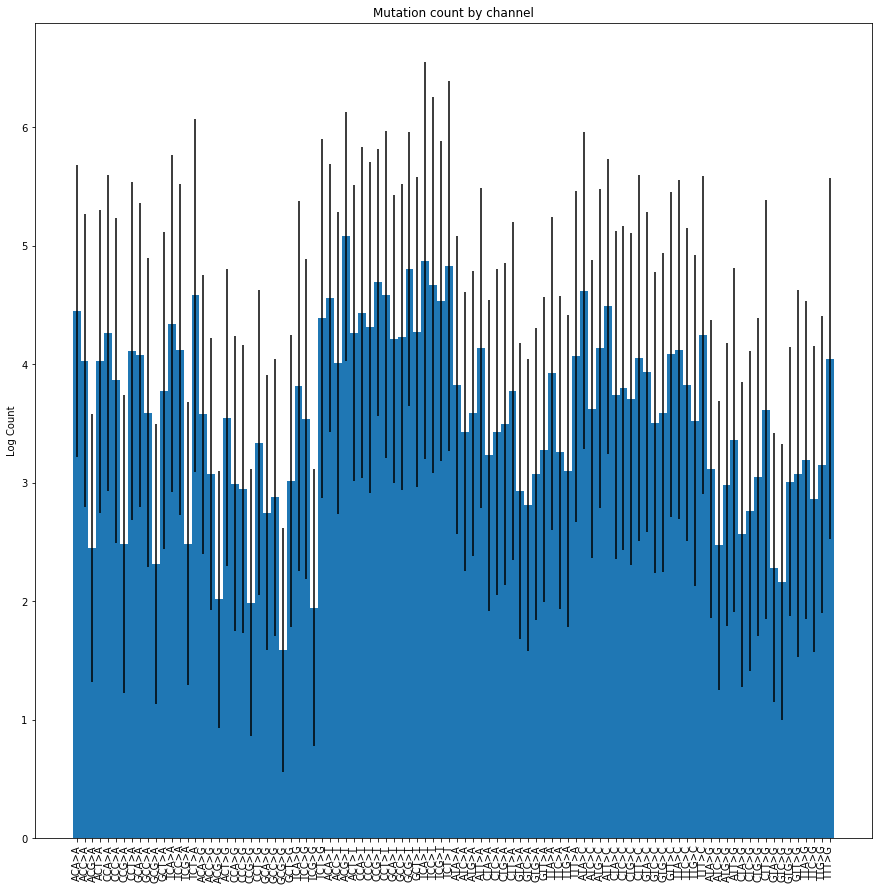

In [0]:
# view average mutation count
plt.figure(figsize = [15, 15])
xn = Normalizer(np.log(raw_tasks[0].X + 1))
N = len(xn.X_mean)
ids = np.arange(N)
plt.bar(ids, xn.X_mean[:N], width = 1.0, yerr = xn.X_std[:N])
# for i in range(N):
#     print(i, channel_names[i], xn.X_mean[i], xn.X_std[i])

plt.ylabel('Log Count')
plt.title('Mutation count by channel')
plt.xticks(ids, channel_names, rotation='vertical')

plt.show()

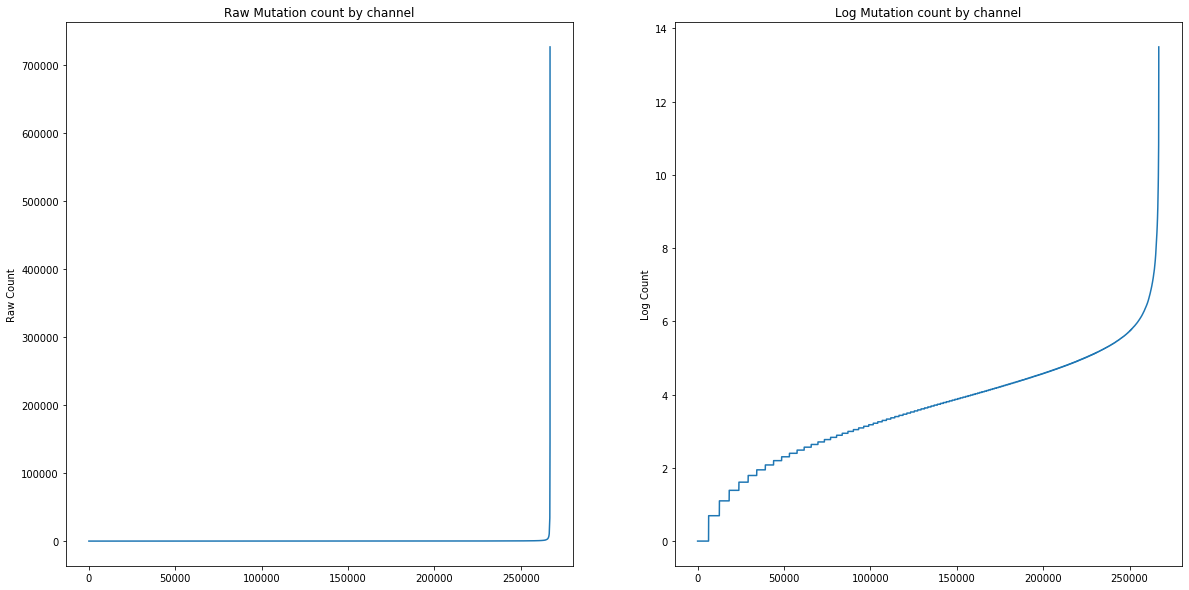

In [0]:
Xs = raw_tasks[0].X.flatten()
plt.figure(figsize = [20, 10])
plt.subplot(121)
plt.plot(sorted(Xs))
plt.ylabel('Raw Count')
plt.title('Raw Mutation count by channel')
plt.subplot(122)
Xs = np.log(Xs + 1)
plt.plot(sorted(Xs))
plt.ylabel('Log Count')
plt.title('Log Mutation count by channel')


plt.show()

In [0]:
class PCAEmbedding:
    def __init__(self, X, m):
        self.X = X
        self.m = m
        self.n = self.X.shape[0]
        C = self.X.T @ self.X / self.n
        self.u, self.s, self.vh = np.linalg.svd(C, full_matrices = True)
    def embed(self, X, m = None):
        return X @ self.u[:, :(self.m if m == None else m)]
    @staticmethod
    def embed_X(X, m):
        pca = PCAEmbedding(X, m)
        return pca, pca.embed(X)

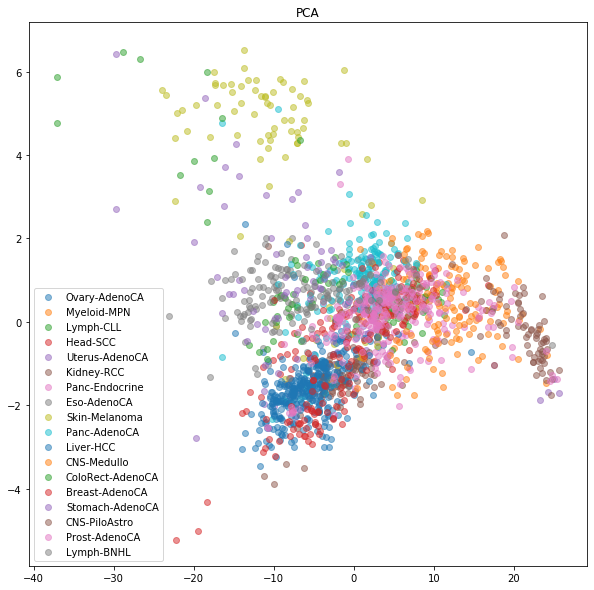

In [0]:
pca, Xs = PCAEmbedding.embed_X(t1tn.X, 2)
plt.figure(figsize = [10, 10])
for name in set(t1tn.Y):
    I = t1tn.Y == name
    plt.scatter(Xs[I][:, 0], Xs[I][:, 1], alpha=0.5, label = name)
plt.legend()
plt.title("PCA")
plt.show()

In [0]:
X = t1tn.X
Y = t1tn.Y
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)

(1867, 2)


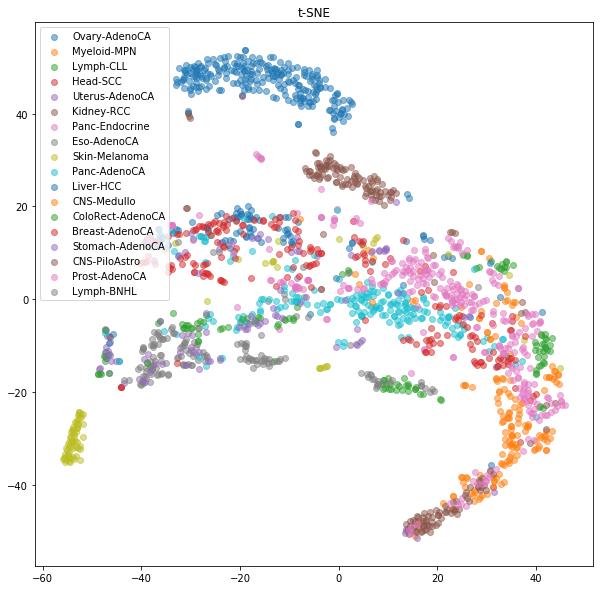

In [0]:
plt.figure(figsize = [10, 10])
for name in set(Y):
    I = Y == name
    plt.scatter(X_embedded[I, 0], X_embedded[I, 1], alpha=0.5, label = name)
plt.legend()
plt.title("t-SNE")
plt.show()

In [0]:

X_em = sklearn.manifold.TSNE(n_components=2).fit_transform(PCAEmbedding.embed_X(t1tn.X, 30)[1])
print(X_em.shape)

(1867, 2)


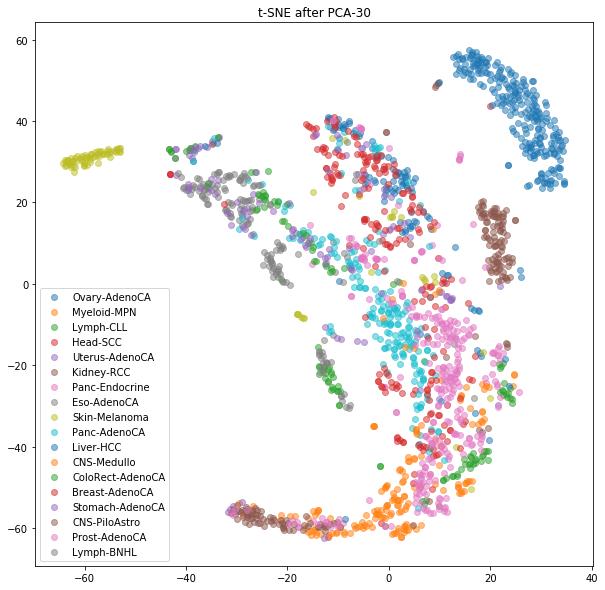

In [0]:
plt.figure(figsize = [10, 10])
for name in set(Y):
    I = Y == name
    plt.scatter(X_em[I, 0], X_em[I, 1], alpha=0.5, label = name)
plt.legend()
plt.title("t-SNE after PCA-30")
plt.show()

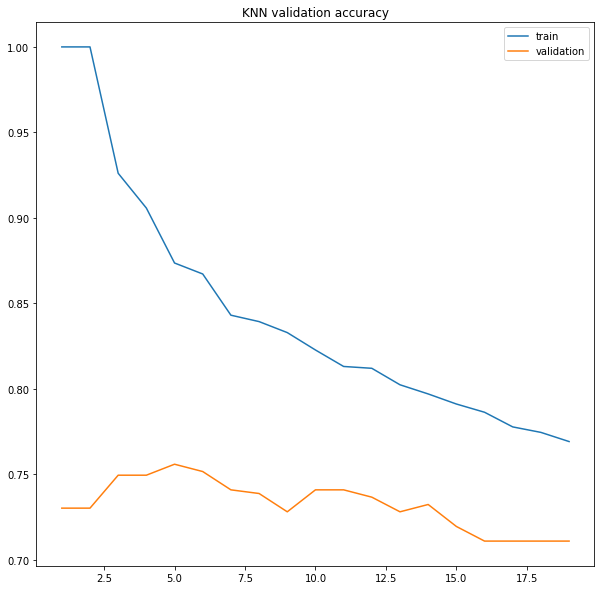

0.7558886509635975 5


In [0]:
class KNN:
    def __init__(self, X, Y, k):
        self.k = k
        self.X = X
        self.Y = Y
    def predict(self, X):
        ds = np.sum((self.X - X) ** 2, axis = 1)
        ids = np.argsort(ds)[:self.k]
        return Counter(self.Y[ids]).most_common()[0][0]
    def predict_all(self, X):
        return np.array([self.predict(X[i]) for i in range(X.shape[0])])

P = 0
Ks, valid_accs, train_accs = [], [], []
if P > 0:
    pca, TXp = PCAEmbedding.embed_X(t1tn.X, P)
    VXp = pca.embed(t1vn.X, P)
else:
    TXp, VXp = t1tn.X, t1vn.X
for K in range(1, 20):
    knn = KNN(TXp, t1tn.Y, K)
    c, t = defaultdict(int), defaultdict(int)
    tc = 0
    y_pred = knn.predict_all(VXp)
    acc = t1vn.evaluate(y_pred)
    valid_accs.append(acc)
    train_accs.append(t1tn.evaluate(knn.predict_all(TXp)))
    # for i in range(t1vn.n):
    #     t[t1vn.Y[i]] += 1
    #     y = knn.predict(VXp[i])
    #     if y[0] == t1vn.Y[i]:
    #         c[t1vn.Y[i]] += 1
    #         tc += 1
    # if K == 6:
    #     for name in t:
    #         print('%15s'%name, '%5d'%c[name], '%5d'%t[name], '%.1f%%' % (c[name] / t[name] * 100))
    Ks.append(K)
    # accs.append(tc / NTest)

plt.figure(figsize = [10, 10])
plt.title("KNN validation accuracy")
plt.plot(Ks, train_accs, label="train")
plt.plot(Ks, valid_accs, label="validation")
plt.legend()
plt.show()
print(np.max(valid_accs), Ks[np.argmax(valid_accs)])

In [0]:
# def PlotConfusionMatrix(confusion):
#     n, m = confusion.shape
#     # normalized
#     norm = confusion / np.sum(confusion, axis = 1)[:, None]
#     df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
#                   columns = [str(i) for i in range(len("ABCDEFGHIJK"))])
#     plt.figure(figsize = (10,7))
#     sn.heatmap(df_cm, annot=True)

##LightGBM

In [0]:
# LightGBM Classifier
from lightgbm import LGBMClassifier

In [0]:
lgbm = LGBMClassifier(objective='multiclass', random_state=5)
lgbm.fit(t1tn.X, t1tn.Y)
y_pred = lgbm.predict(t1vn.X)

In [0]:
t1vn.evaluate(y_pred)

0.7965738758029979

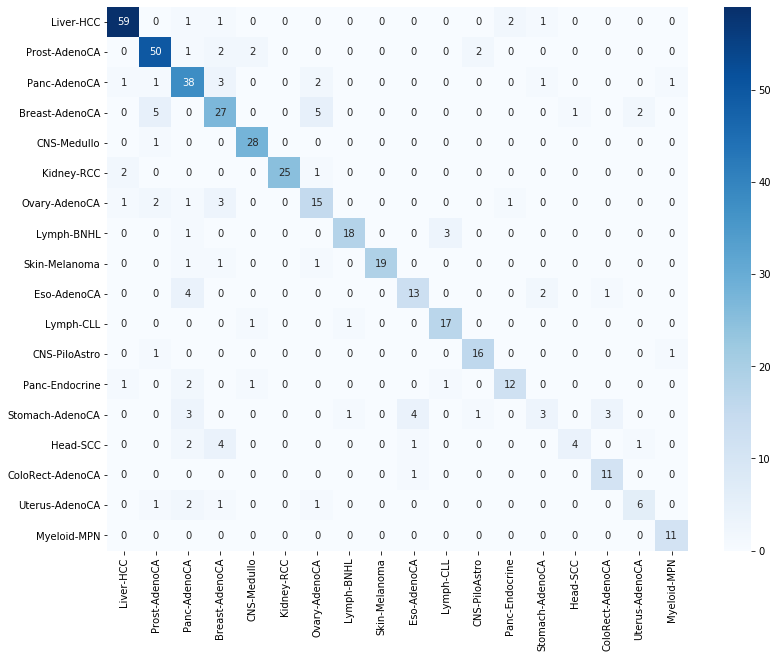

In [0]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

labels = [label for label, count in Counter(t1vn.Y).most_common()]

confm = confusion_matrix(t1vn.Y, y_pred, labels=labels)
df = DataFrame(confm, index=labels, columns=labels)

f, ax = plt.subplots(figsize=(13, 10))
ax = sn.heatmap(df, cmap='Blues', annot=True)
# ax.figure(figsize = [10, 10])


## Multi Layer Percepton - PyTorch


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 20 loss: 0.346, acc: 0.939, validation acc: 0.850
epoch 40 loss: 0.180, acc: 0.969, validation acc: 0.842
epoch 60 loss: 0.143, acc: 0.982, validation acc: 0.850
epoch 80 loss: 0.177, acc: 0.985, validation acc: 0.839
epoch 100 loss: 0.127, acc: 0.978, validation acc: 0.839
epoch 120 loss: 0.091, acc: 0.988, validation acc: 0.844
epoch 140 loss: 0.082, acc: 0.994, validation acc: 0.837
epoch 160 loss: 0.077, acc: 0.989, validation acc: 0.842
epoch 180 loss: 0.037, acc: 0.994, validation acc: 0.848
epoch 200 loss: 0.084, acc: 0.997, validation acc: 0.842


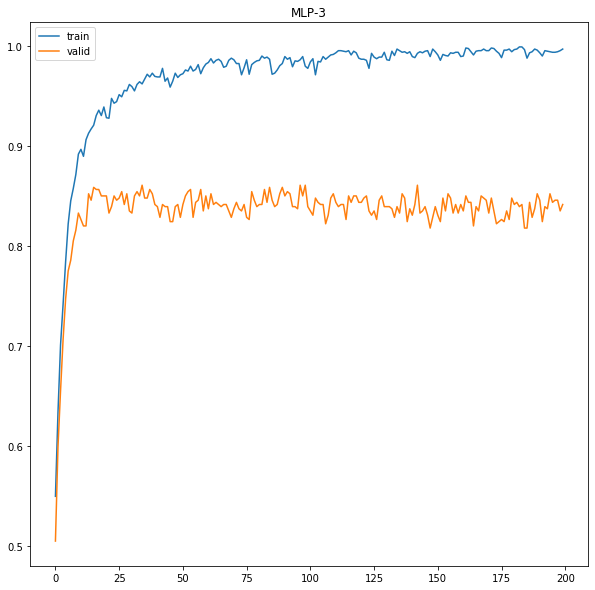

In [0]:
import torch
labels = [label for label, count in Counter(t1vn.Y).most_common()]
def labels_to_int(Y):
    return np.array([labels.index(y) for y in Y])
x_train = torch.tensor(t1tn.X, dtype=torch.float)
y_train = torch.tensor(labels_to_int(t1tn.Y))
x_valid = torch.tensor(t1vn.X, dtype=torch.float)
y_valid = torch.tensor(labels_to_int(t1vn.Y))
from torch.utils.data import TensorDataset
trainset = TensorDataset(x_train, y_train)
validset = TensorDataset(x_valid, y_valid)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

import torch.nn as nn
import torch.nn.functional as F
model = nn.Sequential(
        nn.Linear(96, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, len(labels)),   
        )
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
l1_crit = nn.L1Loss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

train_accs = []
valid_accs = []
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss = sum([l1_crit(param) * 0.0005 for param in model.parameters()], loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_acc = accuracy(model(trainset[:][0]), trainset[:][1])
    valid_acc = accuracy(model(validset[:][0]), validset[:][1])
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    if (epoch + 1) % 20 == 0:
        print('epoch %d loss: %.3f, acc: %.3f, validation acc: %.3f' % (epoch + 1, running_loss / (i+1), train_acc, valid_acc))

plt.figure(figsize = [10, 10])
plt.plot(train_accs, label="train")
plt.plot(valid_accs, label="valid")
plt.legend()
plt.title("MLP-3")
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 20 loss: 0.818, acc: 0.762, validation acc: 0.722
epoch 40 loss: 0.536, acc: 0.835, validation acc: 0.756
epoch 60 loss: 0.454, acc: 0.864, validation acc: 0.788
epoch 80 loss: 0.399, acc: 0.866, validation acc: 0.784
epoch 100 loss: 0.336, acc: 0.892, validation acc: 0.792
epoch 120 loss: 0.308, acc: 0.914, validation acc: 0.846
epoch 140 loss: 0.271, acc: 0.926, validation acc: 0.835
epoch 160 loss: 0.242, acc: 0.941, validation acc: 0.850
epoch 180 loss: 0.186, acc: 0.938, validation acc: 0.842
epoch 200 loss: 0.210, acc: 0.942, validation acc: 0.818


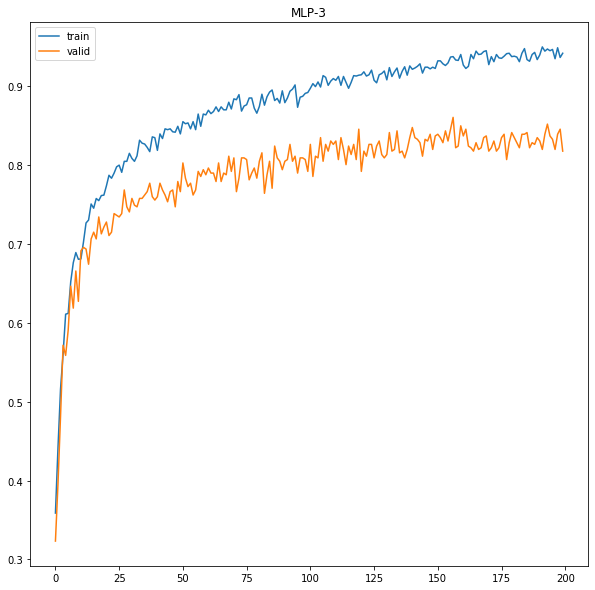

In [0]:

class ResNet(nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
    def forward(self, inputs):
        return self.module(inputs) + inputs
model = nn.Sequential(
        nn.Linear(96, 50),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        ResNet(nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            )),
        nn.Linear(50, len(labels)),   
        )
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
l1_crit = nn.L1Loss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

train_accs = []
valid_accs = []
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_acc = accuracy(model(trainset[:][0]), trainset[:][1])
    valid_acc = accuracy(model(validset[:][0]), validset[:][1])
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    if (epoch + 1) % 20 == 0:
        print('epoch %d loss: %.3f, acc: %.3f, validation acc: %.3f' % (epoch + 1, running_loss / (i+1), train_acc, valid_acc))

plt.figure(figsize = [10, 10])
plt.plot(train_accs, label="train")
plt.plot(valid_accs, label="valid")
plt.legend()
plt.title("MLP-3")
plt.show()